# Tuning curves

For each unit, show firing rate vs an independent variable Y.
The idea is to define bins over Y, take all the time points when Y is in a bin and with that the corresponding spikes, then look at the firing rate (num spikes / num frames) in each bin

In [1]:
# imports
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.signal import medfilt

sys.path.append("./")
sys.path.append(r"C:\Users\Federico\Documents\GitHub\pysical_locomotion")

from data.dbase.db_tables import Probe, Unit, Session, ValidatedSession, Recording, Tracking
from data.data_utils import convolve_with_gaussian

from fcutils.maths.signals import get_onset_offset
from fcutils.plot.figure import clean_axes, calc_nrows_ncols
from myterial import amber_darker, green_dark, grey_darker, blue_darker, grey


save_folder = Path(r"D:\Dropbox (UCL)\Rotation_vte\Locomotion\analysis\ephys")


# print all available recordings
print(*zip(*Recording().fetch("name", "recording_probe_configuration")), sep="\n")

[06/04/22 10:20:51] DEBUG    DPL - Saving data and logs to logs                   ]8;id=474940;file://c:\ProgramData\Miniconda3\envs\dev\lib\site-packages\tpd\core.py\core.py]8;;\:]8;id=783277;file://c:\ProgramData\Miniconda3\envs\dev\lib\site-packages\tpd\core.py#118\118]8;;\

                    DEBUG    Saving log file to: logs\log.log                     ]8;id=269405;file://c:\ProgramData\Miniconda3\envs\dev\lib\site-packages\tpd\core.py\core.py]8;;\:]8;id=684417;file://c:\ProgramData\Miniconda3\envs\dev\lib\site-packages\tpd\core.py#119\119]8;;\

Connecting root@127.0.0.1:3306


[06/04/22 10:20:52] DEBUG    Connected to database: LOCOMOTION                 ]8;id=952274;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\data\dbase\__init__.py\__init__.py]8;;\:]8;id=420421;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\data\dbase\__init__.py#11\11]8;;\

('FC_210715_AAA1110750_r5_hairpin', 'longcolumn')
('FC_210716_AAA1110750_r6_hairpin', 'longcolumn')
('FC_210720_AAA1110750_hairpin', 'longcolumn')
('FC_210721_AAA1110750_hairpin', 'longcolumn')
('FC_210722_AAA1110750_hairpin', 'longcolumn')
('FC_220408_BAA1101192_hairpin', 'r72')
('FC_220409_BAA1101192_hairpin', 'r32')
('FC_220410_BAA1101192_hairpin', 'r64')
('FC_220411_BAA1101192_hairpin', 'r96')
('FC_220413_BAA1101192_hairpin', 'r96')
('FC_220414_BAA1101192_hairpin', 'r48')
('FC_220415_BAA1101192_hairpin', 'r96')
('FC_220432_BAA1101192_hairpin', 'r128')
('FC_220433_BAA1101192_hairpin', 'r128')
('FC_220434_BAA1101192_hairpin', 'r96')
('FC_220435_BAA1101192_hairpin', 'r64')
('FC_211022_BAA110516_hairpin', 'longcolumn')
('FC_211027_BAA110516_hairpin', 'longcolumn')
('FC_211214_BAA110517_hairpin', 'b0')
('FC_220114_BAA110517_hairpin', 'b0')
('FC_220117_BAA110517_hairpin', 'b0')
('FC_220119_BAA110517_hairpin', 'b0')
('FC_220120_BAA110517_hairpin', 'b0')
('FC_210917_BAA1110279_hairpin', 'b

In [2]:
REC = "FC_220408_BAA1101192_hairpin"

metadata = pd.DataFrame(
    (Recording & f'name="{REC}"').fetch()
)

tracking = Tracking.get_session_tracking(REC, body_only=True)
print(tracking)

units = pd.DataFrame(Unit * Unit.Spikes * Probe.RecordingSite & f'name="{REC}"')
units = units.sort_values("brain_region", inplace=False).reset_index()

mouse_id                                                   BAA1101192
name                                     FC_220408_BAA1101192_hairpin
bpname                                                           body
orientation         [20.46860604547166, 2.2873084308201896, 16.283...
angular_velocity    [1228.1163627282995, -1090.8778568790883, 839....
speed               [6.340201506833432, 2.301073842891923, 0.98136...
acceleration        [6.340201506833432, -4.039127663941509, -1.319...
theta               [336.12072186875093, 9.083940881123056, 2.8749...
thetadot            [20167.243312125058, 1977.7931407423273, -372....
thetadotdot         [20167.243312125058, -18189.45017138273, -2350...
x                   [11.474095674820452, 11.417840250675154, 11.43...
y                   [4.503422038204072, 4.419646329903848, 4.44418...
bp_speed            [6.340201506833432, 2.301073842891923, 0.98136...
moving              [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...
walking             

## Define useful functions

In [3]:
def bin_variable(x, bins=10):
    """
    Bin variable x into bins
    and return which frames are in which bin and the bin values
    """

    x = medfilt(x, kernel_size=11)

    # keep only frames within 95th CI
    # low, high = np.percentile(x, [0.5, 99.5])
    # x = x[(x >= low) & (x <= high)]
    if isinstance(bins, int):
        n_bins=bins
    else:
        n_bins = len(bins)-1

    _, edges = np.histogram(x, bins=bins)

    in_bin = dict()
    bin_values = []
    for i in range(n_bins):
        in_bin[i] = np.where((x > edges[i]) & (x <= edges[i + 1]))[0]
        bin_values.append(edges[i]+0.5*(edges[i+1]-edges[i]))

    return in_bin, bin_values


def get_frate_per_bin(unit, in_bin) -> dict:
    """
        Get firing rate per bin by taking all the spikes in a bin and dividing by the number of frames in that bin
    """
    n_ms_per_frame = 1000/60

    # get which unit spikes are in which bin
    in_bin_frate = {}
    for i, bin_frames in in_bin.items():
        n_spikes = len(unit.spikes[np.isin(unit.spikes, bin_frames)])
        n_seconds = len(bin_frames) * n_ms_per_frame / 1000
        in_bin_frate[i] = n_spikes / n_seconds if n_seconds > 0 else np.nan
    return in_bin_frate



def plot_frate_binned_by_var(ax, unit, in_bin:dict, bin_values, xlabel="", color=None):
    """
        Plot a unit's firing rate binned by a variable (with bins defined over the variable's range)
    """
    color = color or unit.color
    # get firing rate per bin
    in_bin_frate = get_frate_per_bin(unit, in_bin)

    # plot firing rate
    ax.plot(bin_values, in_bin_frate.values(), "-o", color=color, lw=2)

    ax.set(xlabel=xlabel, xticks=bin_values[::2])
    ax.set_title(f"Unit {unit.unit_id} - {unit.brain_region}")

## Make plot

NameError: name 'plot_var' is not defined

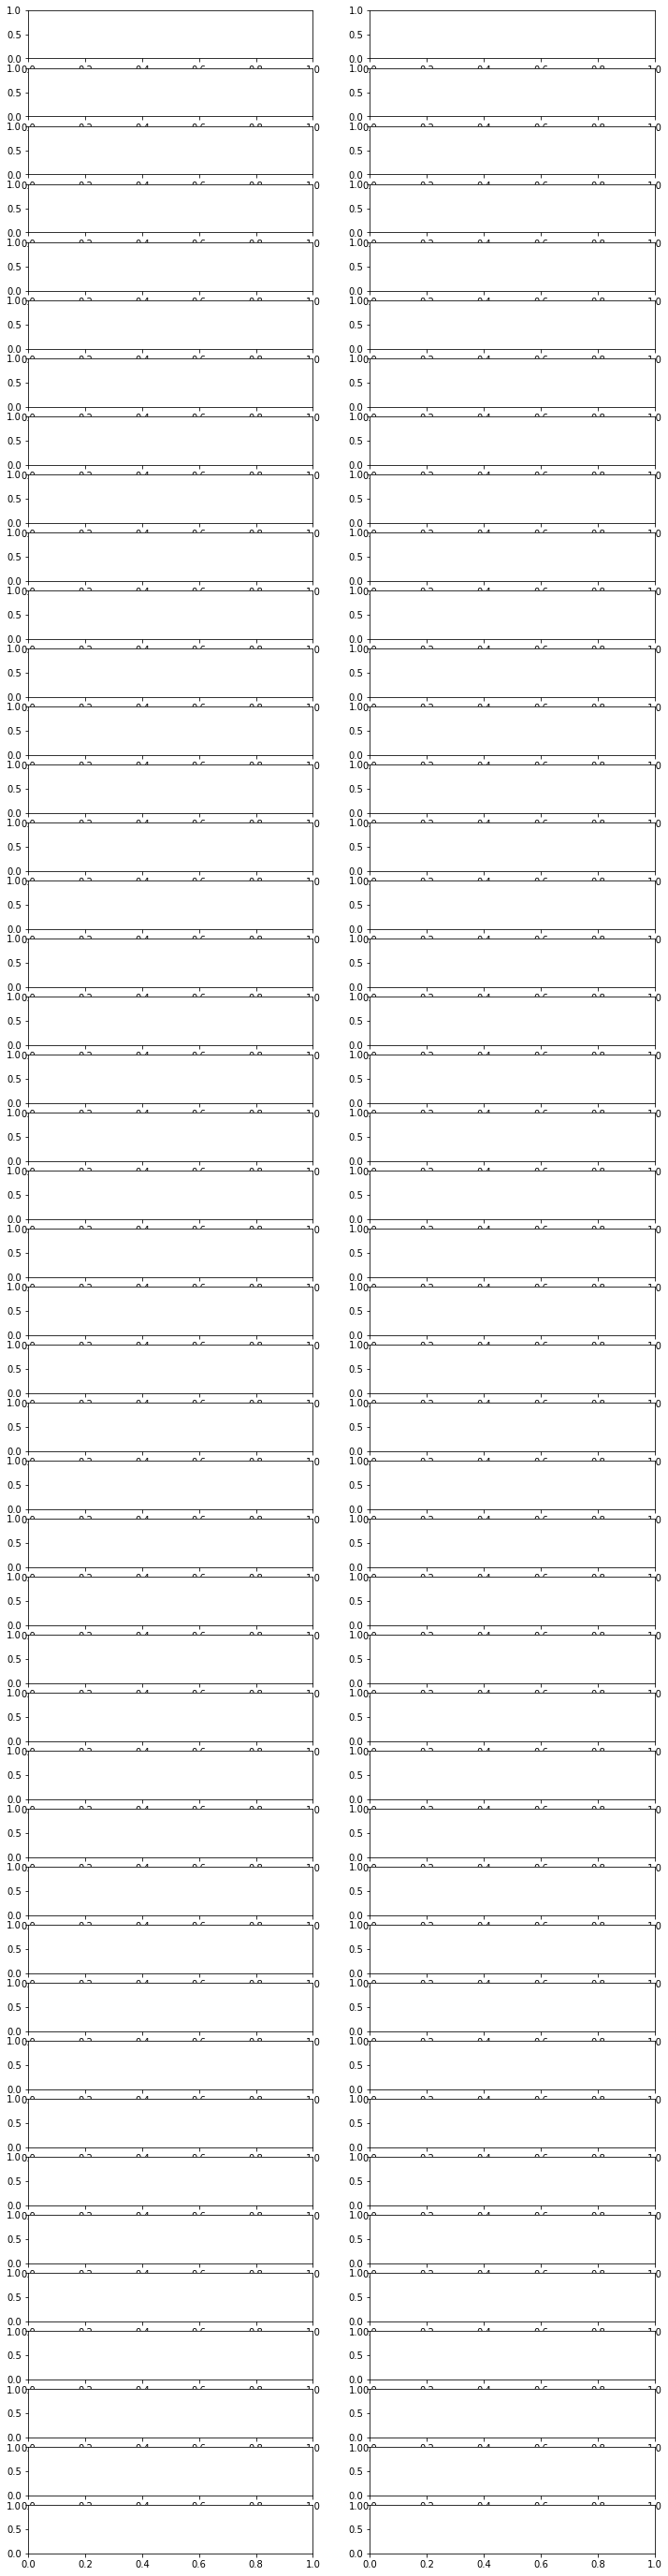

In [4]:
# bin quantities of interest
n_bins = 20
in_bin_speed, bin_values_speed = bin_variable(tracking.speed, bins=np.linspace(-85/n_bins, 85, n_bins)+85/n_bins)
in_bin_avel, bin_values_avel = bin_variable(tracking.thetadot, bins=np.linspace(-500, 500, n_bins)+500/n_bins)
# in_bin_global_coord, bin_values_global_coord = bin_variable(tracking.global_coord, bins=np.linspace(0, 1, n_bins))


nunits = len(units)
f, axes = plt.subplots(nunits, 2, figsize=(12, 50))

for i, unit in units.iterrows():

    # plot_var(i, nunits, axes[i, 0], unit, in_bin_global_coord, bin_values_global_coord, xlabel="GCoord")
    plot_var(i, nunits, axes[i, 0], unit, in_bin_speed, bin_values_speed, xlabel="Speed (cm/s)")
    plot_var(i, nunits, axes[i, 1], unit, in_bin_avel, bin_values_avel, color=blue_darker, xlabel="Angular velocity (deg/s)")

    if i % 10 == 0:
        axes[i, 0].set_ylabel("Firing rate (Hz)")
    # break

f.tight_layout()
clean_axes(f)
f.savefig(save_folder / f"{REC}_units_speed_avel_tuning_curves.png", dpi=800, bbox_inches="tight")